# Train binary meta-models on hard-classes

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, Path(".").absolute().parent.as_posix())

from PIL import Image

import pandas as pd

import numpy as np
from common.meta import get_metafeatures, get_imsize_and_targets

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(12, 10)})

OUTPUT_PATH = Path(".").absolute().parent / "output" / "val_probas"

In [3]:
meta_features_list = [
    OUTPUT_PATH / "val_probas_inceptionv4_350_resized_crop" / "20180428_1633" / "probas.csv",
    OUTPUT_PATH / "val_probas_inceptionv4_350_cls_wts_adam_resized_crop" / "20180520_2026" / "probas.csv",
    OUTPUT_PATH / "val_probas_inceptionv4_350_fc_random_resized_crop" / "20180520_2032" / "probas.csv",
    
    OUTPUT_PATH / "val_probas_resnet152_350_adam_random_crop" / "20180522_1903" / "probas.csv",
    OUTPUT_PATH / "val_probas_resnet152_350_adam_random_crop" / "20180522_1905" / "probas.csv",    
        
    OUTPUT_PATH / "val_probas_inceptionresnetv2_350_resized_crop" / "20180428_1622" / "probas.csv",
    OUTPUT_PATH / "val_probas_inceptionresnetv2_350_weighted_sampler2_resized_crop" / "20180501_1710" / "probas.csv",
    
    OUTPUT_PATH / "val_probas_nasnetalarge_350_resized_crop" / "20180428_1654" / "probas.csv",
    OUTPUT_PATH / "val_probas_nasnetalarge_350_random_resized_crop" / "20180514_2232" / "probas.csv",
    OUTPUT_PATH / "val_probas_nasnetalarge_350_random_resized_crop" / "20180514_2202" / "probas.csv",
]

In [4]:
from common.dataset import FilesFromCsvDataset, TransformedDataset


dataset = FilesFromCsvDataset("../output/unique_filtered_val_dataset.csv")
dataset = TransformedDataset(dataset,
                             transforms=lambda x: (x, Image.open(x).size),
                             target_transforms=lambda l: l - 1)

df_imsize_targets = get_imsize_and_targets(dataset)
y_true = df_imsize_targets['target']

## Get hard classes:

In [5]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

dfs = [pd.read_csv(f, index_col='id') for f in meta_features_list]

In [6]:
df_probas = pd.concat(dfs, axis=0)
y_probas = df_probas.groupby('id').mean()
y_probas = y_probas.loc[y_true.index, :]
y_pred = np.argmax(y_probas.values, axis=1)

1.0 - accuracy_score(y_true, y_pred)

0.11895257863643627

In [9]:
cm = confusion_matrix(y_true, y_pred)
recall_per_class = recall_score(y_true, y_pred, average=None)

idx = np.arange(len(cm))
mcm = cm - cm[idx, idx] * np.eye(len(cm), dtype=np.int)
misclassifed = {}

for i in range(128):
    classes = np.where(mcm[i, :] >= 4)[0]
    values = mcm[i, classes]
    if len(classes) > 0:
        misclassifed[i] = {
            'recall': recall_per_class[i],
            'wrong_classes':[(c, v) for c, v in zip(classes, values)]
        }
        

In [10]:
hard_classes = [k for k in misclassifed if misclassifed[k]['recall'] < 0.65]
hard_classes

[3, 65, 14, 123, 62]

In [177]:
dfs = [pd.read_csv(f, index_col='id') for f in meta_features_list]
dfs = [df.loc[y_true.index, :] for df in dfs]
df_probas = pd.concat(dfs, axis=1)

In [178]:
df_probas.shape

(6263, 1280)

Mean proba baseline

In [188]:
dfs_ = [pd.read_csv(f, index_col='id') for f in meta_features_list]
df_probas_ = pd.concat(dfs_, axis=0)
y_mean_probas = df_probas_.groupby('id').mean()
y_mean_probas = y_mean_probas.loc[y_true.index, :].values

In [194]:
y_mean_pred = np.argmax(y_mean_probas, axis=1)

### Try logistic regression on hard classes

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

In [206]:
cls_index = hard_classes[0]
cls_index

3

In [207]:
seed = 12

X_full = df_probas.values
y_full = (y_true == cls_index).values.astype(np.int)

splt = StratifiedShuffleSplit(test_size=0.25, random_state=seed)

train_index, test_index = next(splt.split(X_full, y_full))

X_trainval = X_full[train_index]
X_test = X_full[test_index]

y_trainval = y_full[train_index]
y_test = y_full[test_index]

y_mean_pred_test = (y_mean_pred[test_index] == cls_index).astype(np.int)

In [208]:
splt = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

log_reg_cv = LogisticRegressionCV(cv=splt, scoring='precision',
                                  class_weight='balanced', 
                                  solver='liblinear',
                                  n_jobs=10, verbose=True, random_state=seed)

In [209]:
log_reg_cv.fit(X_trainval, y_trainval)

[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   26.4s finished


LogisticRegressionCV(Cs=10, class_weight='balanced',
           cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=10, penalty='l2',
           random_state=12, refit=True, scoring='precision',
           solver='liblinear', tol=0.0001, verbose=True)

In [210]:
log_reg_cv.scores_[1].max()

0.8

In [211]:
y_pred = log_reg_cv.predict(X_test)

In [212]:
confusion_matrix(y_test, y_pred), confusion_matrix(y_test, y_mean_pred_test)

(array([[1538,   16],
        [   4,    8]]), array([[1550,    4],
        [   5,    7]]))

In [213]:
recall_score(y_test, y_pred), precision_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.6666666666666666, 0.3333333333333333, 0.9872286079182631)

In [214]:
recall_score(y_test, y_mean_pred_test), precision_score(y_test, y_mean_pred_test), accuracy_score(y_test, y_mean_pred_test)

(0.5833333333333334, 0.6363636363636364, 0.9942528735632183)

In [174]:
def visualize_coefficients(classifier, feature_names=None, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names) if feature_names is not None else np.array(range(len(coef)))
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

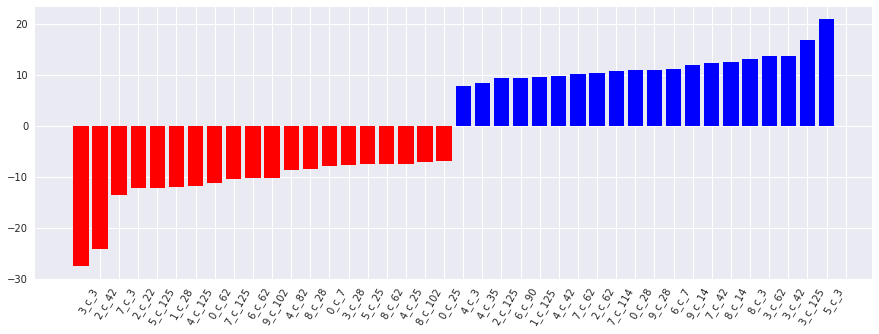

In [175]:
cols = ["{}_c_{}".format(j, i) for j in range(10) for i in range(128)]

visualize_coefficients(log_reg_cv, feature_names=cols, n_top_features=20)

In [145]:
coef = log_reg_cv.coef_.ravel()

In [159]:
n_top_features = 150
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

In [160]:
splt = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

log_reg_cv_2 = LogisticRegressionCV(cv=splt, scoring='precision', 
                                    class_weight='balanced', 
                                    solver='liblinear',
                                    n_jobs=10, verbose=True, random_state=seed)

In [161]:
log_reg_cv_2.fit(X_trainval[:, interesting_coefficients], y_trainval)

[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    5.5s finished


LogisticRegressionCV(Cs=10, class_weight='balanced',
           cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=10, penalty='l2',
           random_state=12, refit=True, scoring='precision',
           solver='liblinear', tol=0.0001, verbose=True)

In [162]:
log_reg_cv_2.scores_[1].max()

0.8571428571428571

In [163]:
y_pred = log_reg_cv_2.predict(X_test[:, interesting_coefficients])

In [164]:
confusion_matrix(y_test, y_pred)

array([[1549,    4],
       [   2,   11]])

In [165]:
recall_score(y_test, y_pred), precision_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.8461538461538461, 0.7333333333333333, 0.9961685823754789)

### Try RF on hard classes

In [297]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score

In [ ]:
65, 123, 62

In [358]:
cls_index = hard_classes[0]
cls_index

3

In [359]:
seed = 12

X_full = df_probas.values
y_full = (y_true == cls_index).values.astype(np.int)

splt = StratifiedShuffleSplit(test_size=0.25, random_state=seed)

train_index, test_index = next(splt.split(X_full, y_full))

X_trainval = X_full[train_index]
X_test = X_full[test_index]

y_trainval = y_full[train_index]
y_test = y_full[test_index]

y_mean_pred_test = (y_mean_pred[test_index] == cls_index).astype(np.int)

In [362]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [369]:
splt = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=seed)

param_grid = {"max_depth": [3, 4, 5],
              "max_features": ['auto', 'log2'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


grid_search = GridSearchCV(rf, param_grid=param_grid, scoring='accuracy', cv=splt, verbose=True, n_jobs=8)
grid_search.fit(X_trainval, y_trainval)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   12.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   28.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   52.7s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': [3, 4, 5], 'max_features': ['auto', 'log2'], 'min_samples_leaf': [1, 3, 10], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False], 'min_samples_split': [2, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [371]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.994 (std: 0.001)
Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.994 (std: 0.002)
Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.994 (std: 0.003)
Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.994 (std: 0.003)
Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'min_samples_split': 3}



In [372]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [373]:
confusion_matrix(y_test, y_pred), confusion_matrix(y_test, y_mean_pred_test)

(array([[1551,    3],
        [   6,    6]]), array([[1550,    4],
        [   5,    7]]))

In [374]:
recall_score(y_test, y_pred), precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.5, 0.6666666666666666, 0.749034749034749)

In [375]:
recall_score(y_test, y_mean_pred_test), precision_score(y_test, y_mean_pred_test), roc_auc_score(y_test, y_mean_pred_test)

(0.5833333333333334, 0.6363636363636364, 0.7903796653796654)